In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import mysql.connector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lstm import LSTM1

cpu


In [121]:
# Establish connection to the database
connection = mysql.connector.connect(
    host="localhost",      
    user="root",
    password="admin",
    database="embedded" 
)
cursor = connection.cursor()
cursor.execute("SELECT * FROM sensor02")


data = cursor.fetchall()

cursor.close()
connection.close()

# Column names
columns = ['serial_no', 'date', 'temperature', 'humidity', 'moisture', 'illumination']

# Create DataFrame
df = pd.DataFrame(data, columns=columns)
df['date'] = pd.to_datetime(df['date'])

# 주차 계산
start_date = df['date'].iloc[0]
df['weeks'] = (df['date'] - start_date).dt.total_seconds() / (7 * 24 * 60 * 60)  # 주 단위로 계산
df['weeks'] = df['weeks'].apply(lambda x: int(x))

test = df.tail().copy()
test.index = test['date']
test = test.drop(columns=['serial_no', 'date'])

In [122]:
mm = MinMaxScaler()
X_test = mm.fit_transform(test)
mm_y = mm.fit_transform(test[['temperature']])
print("Testing Shape", X_test.shape)
X_test_tensors = Variable(torch.Tensor(X_test))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))
print("Testing Shape", X_test_tensors_final.shape)


# GPU setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Hyper parameters
num_epochs = 500
learning_rate = 0.0001
input_size = 5
hidden_size = 256
num_layers = 1
num_classes = 1

# 가중치 파일 불러오기
lstm_model = LSTM1(num_classes, input_size, hidden_size, num_layers, X_test_tensors_final.shape[0]).to(device)
lstm_model.load_state_dict(torch.load('lstm_model.pth', weights_only=True))
lstm_model.eval()  # 모델을 평가 모드로 전환

# 예측 수행 (테스트 데이터에 대한 예측)
test_predict = lstm_model(X_test_tensors_final.to(device))
data_predict_test = test_predict.data.detach().cpu().numpy()
data_predict_test = mm.inverse_transform(data_predict_test)

Testing Shape (5, 5)
Testing Shape torch.Size([5, 1, 5])
cpu


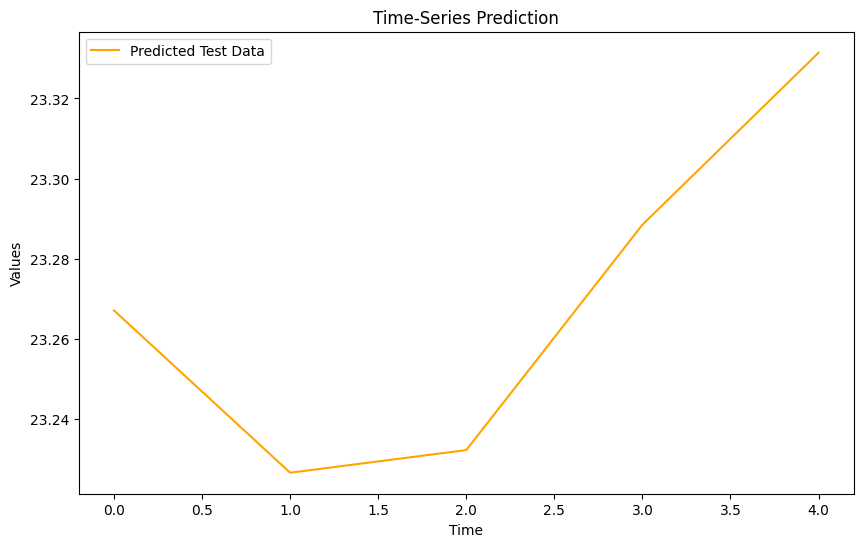

In [123]:
plt.figure(figsize=(10, 6))
plt.plot(data_predict_test, label='Predicted Test Data', color='orange')  # 예측된 테스트 데이터

# 라벨 및 범례
plt.title('Time-Series Prediction')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()